<a href="https://colab.research.google.com/github/YorgosPs/NKGMRES/blob/main/NKGMRES_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple
from time import time

In [30]:
class NKGMRES:

  def __init__(self,
               function,
               atol_n: np.float, 
               rtol_n: np.float, 
               errtol_g: np.float,
               nmax: np.int,
               kmax: np.int,
               N_residuals_plot: np.bool,
               N_updates_plot: np.bool,
               Print_execution_details: np.bool):
    


    '''
    function (Python function): Function to be solved
    atol_n     (real, float): Absolute error tolerance for Newton iterations.
    rtol_n     (real, float): Relative error tolerance for Newton iterations.
    errtol_g     (Real, float): Error tolerance for GMRES iterations. Recommended/default value: 1E-8
    nmax           (Integer>0): Maximum number of Newton iterations. Strongly suggested value: kmax=40.
    kmax           (Integer>0): Maximum number of GMRES iterations. Strongly suggested value: kmax=40.
    N_residuals_plot (Boolean): Plot the residuals of the Newton-Krylov iterations
    N_updates_plot   (Boolean): Plot the updates of the Newton-Krylov iterations
    Print_execution_details (Boolean): Print a more analytic output: Reason for termination,Solution Vector,
                                            Total Number of Iterations, Krylov dimension, Time for execution.
    '''

    assert atol_n>0, 'Unacceptable Absolute Tolerance for Newton.'
    assert rtol_n>0, 'Unacceptable Relative Tolerance for Newton.'
    assert errtol_g>0, 'Unacceptable GMRES Tolerance.'
    assert kmax>0 and int(kmax)==kmax, 'Unacceptable kmax parameter.'
    assert nmax>0 and int(nmax)==nmax, 'Unacceptable nmax parameter.'
  
    self.function = function
    self.atol_n = atol_n
    self.rtol_n = rtol_n
    self.errtol_g = errtol_g
    self.nmax = nmax
    self.kmax = kmax
    self.N_residuals_plot = N_residuals_plot
    self.N_updates_plot = N_updates_plot
    self.Print_execution_details = Print_execution_details


  '''
  Function nk_gmres:
  Core NKGMRES Solver.
  Given an initial condition and necessary function parameters, find the closest root.
  '''

  def nk_gmres(self,
               y1:  np.ndarray,
               args: Tuple)   -> np.ndarray:

    '''
    INPUT
    y1       (Nx1 numpy array): Initial guess of the solution. 
    args               (Tuple): A tuple with any arguments the function needs
  
    OUTPUT
    y1       (Nx1 numpy array): Solution vector
    '''
    
    #Start timing
    time_start = time()

    #Dimension of input/output
    N = y1.shape[0]

    #Residual Sequence for Newton residuals 
    RHO = [np.linalg.norm(self.function(y1, args))]

    #Residual Sequence for Newton Updates
    RHOu = []

    #Sequence of Krylov dimensions
    krylov_dimension = []

    # Newton Iterations
    for z in range(self.nmax):    

        y2, krylov= self.GMRES(self.function,
                               y1,
                               args)
        #Append update
        RHOu.append(np.linalg.norm(y2-y1))

        y1=y2

        #Update residual
        err_newton_residual= np.linalg.norm(self.function(y2, args))
        RHO.append(err_newton_residual)

        #Update Krylov dimension
        krylov_dimension.append(krylov)

        #Break if converged
        if err_newton_residual<self.atol_n +  self.rtol_n * np.linalg.norm(y2):
            break

    #Stop timing
    time_end = time()


    # Test for termination
    if err_newton_residual>self.atol_n +  self.rtol_n * np.linalg.norm(y2):

        print('Non-convergence. Try greater number of iterations, different initial condition, larger error tolerance or check the equations.')

    # Optionally print execution details (Vector, Iterations, Krylov dimension, Execution time)
    if self.Print_execution_details:    

        print('Solution Vector:', y1)
        print('Total Number of Newton Iterations:', z)
        print('Maximum Krylov dimension:', max(krylov_dimension) + 1)  # NEED TO REMEMBER WHY +1...
        print('Execution time: ', time_end-time_start,' s' )                 

    # Optionally plot the Newton Residuals (useful when checking for quadratic convergence)
    if self.N_residuals_plot:

        fig, ax = plt.subplots(figsize = [10,7])
        ax.semilogy(RHO, '-o')
        ax.grid(True)
        ax.set_xlabel('Iteration', fontsize=15)
        ax.set_ylabel('$||F(x_n)||_2$', fontsize=15)
        ax.set_title('Error vs Newton Iterations', fontsize=18)

    # Optionally plot the Newton Updates (useful when checking for quadratic convergence)
    if self.N_updates_plot:

        fig, ax = plt.subplots(figsize = [10,7])
        ax.semilogy(RHOu, '-o')
        ax.grid(True)
        ax.set_xlabel('Iteration', fontsize=15)
        ax.set_ylabel('$||x_{n+1} -x_{n}||_2$', fontsize=15)
        ax.set_title('Updates vs Newton Iterations', fontsize=18)

    return y1



  '''
  Function matvec:
  Define a matrix-vector product to be used to construct the Krylov subspace.
  Here the matrix is the Jacobian and the vector is the residual at the current 
    Newton iteration.
  '''

  def matvec(self,
             x: np.ndarray,
             y: np.ndarray,
             args: Tuple,
             epsilon0 = 1E-4) -> np.ndarray:
    
    '''
    INPUT
    x       (Nx1 numpy array): Vector for directional derivative (here, residual vector) - b
    y       (Nx1 numpy array): State at which the Jacobian needs to be estimated  -  J(y)
    args              (Tuple): A tuple with any arguments the function needs
    epslion0          (float): Magnitude of the perturbation to approximate Dir. Der. 
  
    OUTPUT 
    MVP     (Nx1 numpy array): Marix-Vector Product  -  J(y) dot b
    '''

    assert epsilon0>0, 'Unacceptable epsilon'

    maxterm = np.max([np.abs(y @ x), np.linalg.norm(x)]) * np.sign(y @ x) / np.linalg.norm(x)
    epsilon = epsilon0 / np.linalg.norm(x) * maxterm

    #Estimating the directional derivative with finite differences
    yonly = self.function(y, args)
    yplus = self.function(y + x * epsilon, args)
    MVP=(yplus-yonly)/epsilon

    return MVP


  def GMRES(self,
            matvec,
            y1 :np.ndarray,                                                                      #How can I make GMRES applicable in general??
            args: Tuple) -> Tuple[np.ndarray, np.int]:


    '''
    INPUT
    matvec (Python function): A Python function to perform Newton on.
    y1          (N x 1 vector): Initial guess of the solution. 
    args               (Tuple): A tuple with any argument the equation function needs
  
    OUTPUT
    yn1             (Nx1 numpy array): Next iterate
    newton_residual (Nx1 numpy array): Residual corresponding to the next iterate
    krylov_dimension        (Integer): Number of Krylov dimensions used by GMRES

    '''


    # Given's Rotation
    def givapp(c,s,vin,k):                                                        ### There must be a smarter way to write this..
        vrot = vin

        for i in range(k):
            w1 = c[i] * vrot[i] - s[i] * vrot[i+1]
            w2 = s[i] * vrot[i] + np.conj(c[i]) * vrot[i+1]
            vrot[i], vrot[i+1] = w1, w2

        return vrot

    #Dimension of the problem
    N = y1.shape[0]

    #GMRES counter (starting from -1 because adapted from Matlab)                    #### Indexing should be fixed
    k = -1  

    #Flag for code termination
    code_break = False

    #RHS of Newton method (and GMRES)
    b = -1 * self.function(y1, args)

    #Initial Residual
    residual = np.linalg.norm(b)
    
    #Initialize Krylov subspace dimension counter
    krylov_dimension = 0


    # Test for termination on entry - checking for Newton residual
    if residual<self.atol_n +  self.rtol_n * np.linalg.norm(y1):
        if self.Print_execution_details:
            print('Successful Convergence: The norm of F(xn) is less than the Newton convergence tolerance')
        
        krylov_dimension = 0
        code_break = True

    #Initializing the arrays for Gram-Schmidt
    h, v = np.zeros([self.kmax,self.kmax]), np.zeros([N,self.kmax])
    
    #Initializing the arrays for Givens rotation
    c, s = np.zeros([self.kmax+1,1]) ,np.zeros([self.kmax+1,1])      

    #Initial guess for GMRES: zero vector
    x = np.zeros(N) 
    x0 = np.zeros(N)

    #Setting initial residual of GMRES                                                  ????? Are all of these necessary??
    r = b
    rho = residual
    g = rho * np.eye(self.kmax+1,1)

    errtol_g = self.errtol_g * residual

    # Test for termination on entry - checking for GMRES residual
    if rho<errtol_g:
        if self.Print_execution_details:
            print('Reason for termination: The norm of the GMRES residual is lower than the error before the GMRES iter. starts')
        krylov_dimension = 0
        code_break = True


    #Normalize error vector
    v[:,0] = r / rho
    beta = rho


    # GMRES Iterations
    while rho>errtol_g and k<self.kmax - 2 and not code_break:

        k+=1

        #####CGS2#####
        #Producing vectors out of matrix-vector multiplications 
        v[:,k+1] = self.matvec(v[:,k], y1, args)

        #Modified Gram-Schmidt orthogonalization of the vectors above
        for j in range(k+1):
            h[j,k] = v[:,j].T @ v[:,k+1]  
            v[:,k+1] = v[:,k+1] - h[j,k] * v[:,j]
        
        h[k+1,k] = np.linalg.norm(v[:,k+1])

        # Reorthogonalization (CGS-2)
        for j in range(k):
            hr = v[:,j].T @ v[:,k+1]
            h[j,k] = h[j,k] + hr
            v[:,k+1] = v[:,k+1] - v[:,j] * hr
        
        h[k+1,k] = np.linalg.norm(v[:,k+1])

        # Happy-Breakdown Test                                                      ??????????????????
        if h[k+1,k]!=0:
            v[:,k+1] = v[:,k+1] / h[k+1,k]

        #####GIVENS_ROTATION#####
        if k>0:
            h[0:k+1,k] = givapp(c[0:k], s[0:k], h[0:k+1,k], k)                   

        nu = np.linalg.norm(h[k:k+2,k]) 

        #If nu=0 this means that we have span the entire Krylov space
        if nu!=0:
            c[k] = np.conj(h[k,k] / nu)
            s[k] = -1 * h[k+1,k] / nu
            h[k,k] = c[k] * h[k,k] - s[k] * h[k+1,k]
            h[k+1,k] = 0
            g[k:k+2] = givapp(c[k],s[k], g[k:k+2],1)                          
        
        rho = abs(g[k+1])       

        krylov_dimension = k

    if np.linalg.det(h[0:k+1,0:k+1])==0 and k<self.kmax:
        if self.Print_execution_details:
            print('Zero determinant - GMRES fails to find a solution')
        k=self.kmax                                                             #???????????????????



    y = np.linalg.inv(h[0:k+1,0:k+1]) @ g[0:k+1]
    x = x0 + (v[0:N,0:k+1] @ y).T
    x = x[0]

    yn1 =y1 + x

    return yn1, krylov_dimension

Solution Vector: [-2.00000002  3.99999995 -0.99999999]
Total Number of Newton Iterations: 5
Maximum Krylov dimension: 3
Execution time:  0.029466867446899414  s


array([-2.00000002,  3.99999995, -0.99999999])

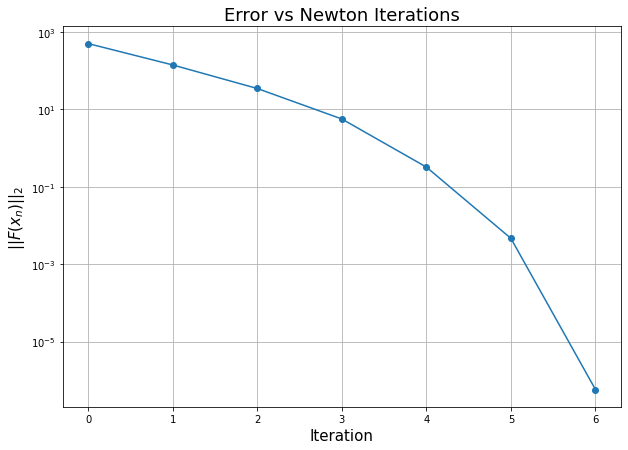

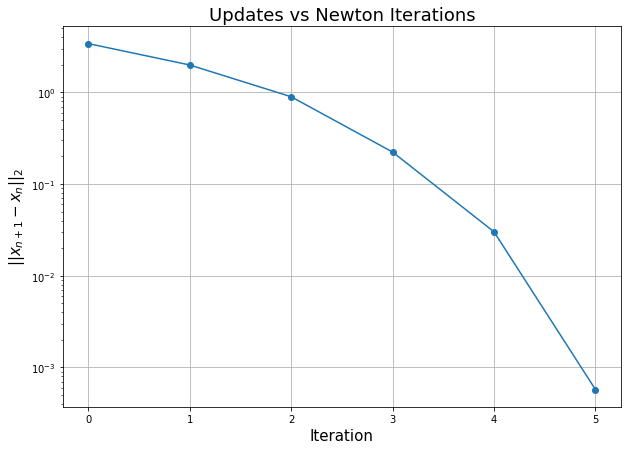

In [45]:
def funcc(x, p): #8, 32
  return np.array([x[0]**3 + p[0],  x[1]**2*x[0]- p[1], p[2]*x[2]**2-x[1]])

NKGMRES1=  NKGMRES(function = funcc,
               atol_n=1E-7, 
               rtol_n=1E-5, 
               errtol_g=1E-8,
               nmax=10,
               kmax=40,
               N_residuals_plot=True,
               N_updates_plot=True,
               Print_execution_details=True)  

y00 = np.array([-6, 9, -0.8])

NKGMRES1.nk_gmres(y00, np.array([8,-32, 4]))